## Imports + Setup

In [204]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

from neural_data import *
from deepjuice import *

import torch
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Inspect NSD fMRI data

In [3]:
benchmark = NaturalScenesDataset()

### Stimulus image information

In [4]:
print(f"There are {benchmark.stimulus_data.shape[0]} stimulus images")
benchmark.stimulus_data.head()

There are 1000 stimulus images


,index,image_name,image_path,coco_id,coco_supercategs,coco_categs,coco_areas,coco_captions
0,coco_264244,shared0014_nsd03627.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,264244,"['animal', 'person', 'furniture', 'electronic'...","['cat', 'person', 'bed', 'laptop', 'book', 'la...","[6110.812749999999, 40009.08360000001, 108675....",['Man laying on top of bed in green towel work...
1,coco_267699,shared0036_nsd04787.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,267699,"['vehicle', 'vehicle', 'vehicle', 'vehicle', '...","['car', 'car', 'car', 'car', 'bus', 'bus', 'bu...","[1692.3434000000013, 1032.3574500000004, 113.6...","[""a city's traffic with buses, cars and pedest..."
2,coco_268114,shared0040_nsd04931.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,268114,"['vehicle', 'vehicle', 'vehicle']","['boat', 'boat', 'boat']","[1825.7513000000001, 14098.474599999998, 113.5...","['A couple of white boats on the water.', 'thr..."
3,coco_531392,shared0045_nsd05302.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,531392,['indoor'],['vase'],[15927.302749999999],['A red vase sitting on top of a piano filled ...
4,coco_270278,shared0053_nsd05603.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,270278,['outdoor'],['stop sign'],[4444.39525],['A stop sign by a beach next to some placid w...


In [216]:
benchmark.stimulus_data.index

RangeIndex(start=0, stop=1000, step=1)

### fMRI voxel metadata

In [5]:
benchmark.metadata.head()

,subj_id,roi_name,roi_voxel_idx,voxel_reliability,roi_group,roi_level
voxel_id,,,,,,
8520,1,V1v,0,0.156360,Early Visual Cortex,Early Visual Cortex
8521,1,V1v,1,0.263088,Early Visual Cortex,Early Visual Cortex
8522,1,V1v,2,0.253195,Early Visual Cortex,Early Visual Cortex
8523,1,V1v,3,0.132281,Early Visual Cortex,Early Visual Cortex
8524,1,V1v,4,0.117597,Early Visual Cortex,Early Visual Cortex


In [105]:
cortical_regions = benchmark.metadata['roi_name'].unique()
print(f"There are {benchmark.metadata.shape[0]} recorded voxels across {len(cortical_regions)} cortical regions:")
print(cortical_regions)

There are 8461 recorded voxels across 19 cortical regions:
['V1v' 'V2v' 'V3v' 'V1d' 'V2d' 'V3d' 'hV4' 'OFA' 'FFA-1' 'FFA-2' 'OWFA'
 'VWFA-1' 'VWFA-2' 'EBA' 'FBA-1' 'FBA-2' 'OPA' 'PPA' 'RSC']


### fMRI response data

In [108]:
print(f'There are {benchmark.response_data.shape[0]} voxels recorded on {benchmark.response_data.shape[1]} stimulus images')
benchmark.response_data.head()

There are 8461 voxels recorded on 1000 stimulus images


### Example image with descriptions

In [218]:
benchmark.stimulus_data

,index,image_name,image_path,coco_id,coco_supercategs,coco_categs,coco_areas,coco_captions
0,coco_264244,shared0014_nsd03627.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,264244,"['animal', 'person', 'furniture', 'electronic'...","['cat', 'person', 'bed', 'laptop', 'book', 'la...","[6110.812749999999, 40009.08360000001, 108675....",['Man laying on top of bed in green towel work...
1,coco_267699,shared0036_nsd04787.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,267699,"['vehicle', 'vehicle', 'vehicle', 'vehicle', '...","['car', 'car', 'car', 'car', 'bus', 'bus', 'bu...","[1692.3434000000013, 1032.3574500000004, 113.6...","[""a city's traffic with buses, cars and pedest..."
2,coco_268114,shared0040_nsd04931.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,268114,"['vehicle', 'vehicle', 'vehicle']","['boat', 'boat', 'boat']","[1825.7513000000001, 14098.474599999998, 113.5...","['A couple of white boats on the water.', 'thr..."
3,coco_531392,shared0045_nsd05302.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,531392,['indoor'],['vase'],[15927.302749999999],['A red vase sitting on top of a piano filled ...
4,coco_270278,shared0053_nsd05603.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,270278,['outdoor'],['stop sign'],[4444.39525],['A stop sign by a beach next to some placid w...
...,...,...,...,...,...,...,...,...
995,coco_553166,shared0152_nsd12496.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,553166,"['sports', 'person']","['surfboard', 'person']","[2050.789849999999, 3626.2101000000002]",['Surfer riding atop a Avery large wave about ...
996,coco_123692,shared0515_nsd39048.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,123692,"['person', 'person', 'sports', 'sports', 'outd...","['person', 'person', 'baseball bat', 'baseball...","[11872.945049999995, 1566.2535999999977, 625.5...",['there is a baseball game on and a player is ...
997,coco_198195,shared0583_nsd43430.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,198195,"['person', 'food', 'food', 'food']","['person', 'orange', 'orange', 'orange']","[54845.30970000001, 36042.8992, 47571.06935000...",['Three small oranges being held in one hand.'...
998,coco_414853,shared0638_nsd46481.png,/home/facosta/deepjuice/DeepNSD/neural_data/na...,414853,"['animal', 'animal']","['horse', 'horse']","[38057.36585000002, 18394.379149999993]",['A large light brown horse standing next to a...


Image description: f['A man holding a surfboard standing on a wave covered ocean.', 'A woman entering the ocean with her surfboard', 'A person in the surf with a large surfboard.', 'a person holding a surf board in a body of water', 'a person is holding a surf board on the waves']


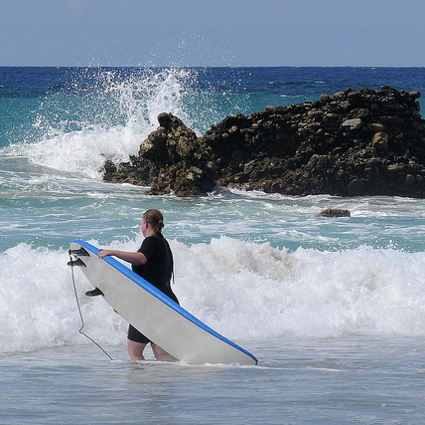

In [8]:
stimulus_id = 59

print(f"Image description: f{benchmark.stimulus_data.loc[stimulus_id]['coco_captions']}")
benchmark.view_sample_stimulus(stimulus_id)

In [9]:
benchmark.response_data.index

Index([ 8520,  8521,  8522,  8523,  8524,  8525,  8526,  8527,  8528,  8529,
       ...
       17035, 17036, 17037, 17038, 17039, 17040, 17041, 17042, 17043, 17044],
      dtype='int64', name='voxel_id', length=8461)

In [10]:
benchmark.metadata.index

Index([ 8520,  8521,  8522,  8523,  8524,  8525,  8526,  8527,  8528,  8529,
       ...
       17035, 17036, 17037, 17038, 17039, 17040, 17041, 17042, 17043, 17044],
      dtype='int64', name='voxel_id', length=8461)

In [15]:
benchmark.rdm_indices = benchmark.get_rdm_indices(['roi_name','subj_id'])
len(benchmark.rdm_indices['V1v'][1])

479

In [11]:
benchmark.rdms = benchmark.get_rdms(group_vars = ['roi_name', 'subj_id'])
benchmark.rdms['V1v'][1].shape

(1000, 1000)

### Organize fMRI voxel responses according to functional region in dict 'neural_data':

In [202]:
neural_data = {}
for region in cortical_regions:
    region_voxel_idx = benchmark.metadata[
        benchmark.metadata["roi_name"] == region
    ].index
    neural_data[region] = benchmark.response_data.loc[region_voxel_idx]
    print(f"Region {region} has {len(neural_data[region])} voxels")

neural_data["V1v"].head()

Region V1v has 479 voxels
Region V2v has 550 voxels
Region V3v has 404 voxels
Region V1d has 631 voxels
Region V2d has 453 voxels
Region V3d has 405 voxels
Region hV4 has 372 voxels
Region OFA has 172 voxels
Region FFA-1 has 239 voxels
Region FFA-2 has 127 voxels
Region OWFA has 227 voxels
Region VWFA-1 has 434 voxels
Region VWFA-2 has 170 voxels
Region EBA has 2002 voxels
Region FBA-1 has 182 voxels
Region FBA-2 has 183 voxels
Region OPA has 851 voxels
Region PPA has 399 voxels
Region RSC has 181 voxels


,coco_264244,coco_267699,coco_268114,coco_531392,coco_270278,coco_10710,coco_273250,coco_538822,coco_283426,coco_549301,...,coco_123891,coco_14269,coco_178423,coco_202050,coco_386856,coco_553166,coco_123692,coco_198195,coco_414853,coco_442489
voxel_id,,,,,,,,,,,,,,,,,,,,,
8520,1.225205,0.590935,0.121206,0.549895,-0.340116,0.171882,0.945140,-0.242189,-0.501543,1.202971,...,0.678956,-1.262334,0.328617,-0.280216,0.895930,0.712224,0.610018,-0.234807,0.882929,-1.387336
8521,1.267595,0.743550,0.966085,0.378369,0.272476,0.196839,1.409024,0.576764,-0.727952,0.761293,...,1.256518,-0.542324,0.564668,0.222338,0.955391,0.274166,0.340416,-0.280754,0.964017,-0.737819
8522,0.997962,0.581113,1.135900,0.623025,0.023354,0.412820,0.926945,0.381630,-0.774300,0.571883,...,1.045422,-1.269126,0.573224,0.049556,1.105734,0.417626,0.099971,-0.058198,1.082593,-0.640127
8523,0.215511,-0.116404,0.419171,0.318863,-0.498560,1.054046,1.119572,0.778312,0.008422,0.428147,...,0.024606,-0.888920,0.995822,-0.039486,1.122496,-0.464239,-0.025626,0.113139,0.035508,-1.194936
8524,0.361521,-0.094618,0.313835,-0.282890,0.273159,0.276640,0.138759,0.417800,-0.151335,0.854391,...,-0.100879,-0.543191,-0.249918,0.490013,1.409335,-0.040840,-0.065341,0.216428,0.281004,-0.111645


## Compute PCA of voxel responses

In [201]:
def compute_power_law_index(activations):
    # Perform PCA on the activations
    pca = TorchPCA(device="cuda").fit(activations)
    eigvals = pca.explained_variance_
    ranks = torch.arange(1, len(eigvals) + 1)

    log_ranks = torch.log(ranks.float())[:-1]
    log_eigvals = torch.log(eigvals.float())[:-1]

    knee_locator = KneeLocator(
        log_ranks.cpu(),
        log_eigvals.cpu(),
        curve="concave",
        direction="decreasing",
        online=True,
    )
    knee_x = knee_locator.knee
    knee_y = knee_locator.knee_y

    # Filter the data based on the knee point's position
    linear_region_indices = torch.where(log_ranks <= knee_x)
    log_ranks_linear = log_ranks[linear_region_indices]
    log_eigvals_linear = log_eigvals[linear_region_indices]

    # Create the design matrix and move it to the GPU
    X = torch.vstack((log_ranks_linear, torch.ones_like(log_ranks_linear))).T
    X = X.to("cuda")
    Y = log_eigvals_linear.view(-1, 1).to("cuda")

    # Solve the normal equations
    result = torch.linalg.lstsq(X, Y)

    # Extract the slope which is our alpha (power law index) and intercept
    slope, y_intercept = result.solution.cpu().squeeze().numpy()

    return slope, y_intercept, log_ranks.cpu(), log_eigvals.cpu()

### Plot PCA eigenspectrum for one region

Slope: -1.0312264
Intercept: 3.9860365


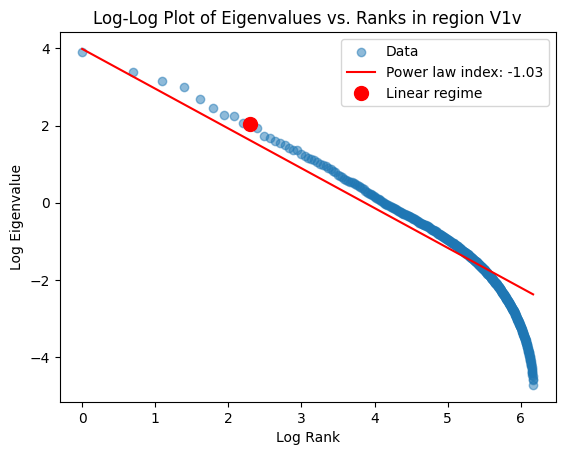

In [200]:
region = "V1v"

# Compute the power law index and get the log-ranks and log-eigenvalues
slope, y_intercept, log_ranks, log_eigvals = compute_power_law_index(
    neural_data[region].to_numpy()
)

print("Slope:", slope)
print("Intercept:", intercept)

# Create a scatter plot of the log-ranks and log-eigenvalues
plt.scatter(log_ranks, log_eigvals, label="Data", alpha=0.5)

# Plot the line corresponding to the computed power law index
plt.plot(
    log_ranks,
    slope * log_ranks + intercept,
    color="red",
    label=f"Power law index: {slope:.2f}",
)

# Add labels and a legend
plt.xlabel("Log Rank")
plt.ylabel("Log Eigenvalue")
plt.title(f"Log-Log Plot of Eigenvalues vs. Ranks in region {region}")

# Show point corresponding to end of linear (power law) regime
if knee_x is not None and knee_y is not None:
    plt.plot(knee_x, knee_y, "ro", markersize=10, label="Linear regime")

plt.legend()
plt.show()

### Compute PCA with fixed n_components for all regions

In [199]:
n_components = 127

pca_neural_data = {}
pca_ev_ratio = {}
for region in cortical_regions:
    pca = TorchPCA(n_components=n_components, device="cuda").fit(
        neural_data[region].to_numpy()
    )
    X = pca.get_top_n_components(n_components=n_components).T
    pca_neural_data[region] = pd.DataFrame(X.cpu(), columns=neural_data[region].columns)
    pca_ev_ratio[region] = pca.total_explained_variance_ratio_

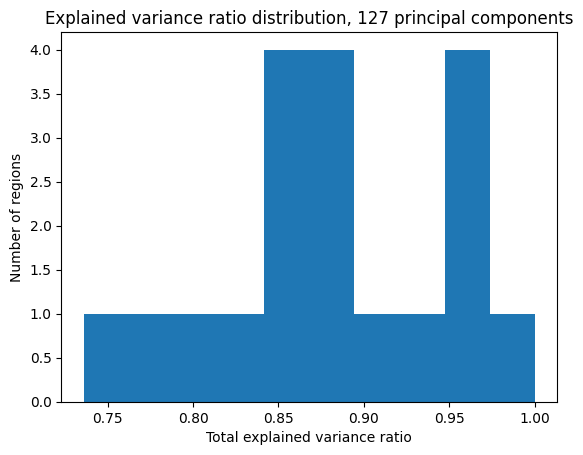

In [197]:
plt.hist(pca_ev_ratio.values())
plt.xlabel("Total explained variance ratio")
plt.ylabel("Number of regions")
plt.title(f"Explained variance ratio distribution, {n_components} principal components");

## Compute shape-based distances between cortical networks

### Perform 80/20 Train/Test data split

In [275]:
seed = 2023
rng = np.random.default_rng(seed)

n_features, n_classes = pca_neural_data["V1v"].shape

# random indices for training set
idx_train = rng.choice(np.arange(n_classes), int(n_classes * 0.8), replace=False)

train_images = benchmark.stimulus_data.loc[idx_train]["index"]

# everything left over is test set
idx_test = np.array(list(set(np.arange(n_classes)).difference(idx_train)))

test_images = benchmark.stimulus_data.loc[idx_test]["index"]

train_dict = {
    region: pca_neural_data[region][train_images].to_numpy().T
    for region in cortical_regions
}

test_dict = {
    region: pca_neural_data[region][test_images].to_numpy().T
    for region in cortical_regions
}

train_data = list(train_dict.values())

test_data = list(test_dict.values())

### Initialize metric

In [190]:
from netrep.metrics import LinearMetric

We choose a metric from a family of linear metrics parameterized by $\alpha \in [0,1]$, where

$\alpha = 0$ corresponds to [Canonical Correlation Analysis (CCA)](https://en.wikipedia.org/wiki/Canonical_correlation)

$\alpha = 1$ corresponds to [Procrustes distance](https://en.wikipedia.org/wiki/Procrustes_analysis)

In [285]:
alpha = 0

metric = LinearMetric(alpha=alpha, center_columns=True, score_method="angular")

# difference between 'angular' and 'euclidean' score_method?
# which value of alpha should we use?

### Compute region-region pairwise distance matrix

In [287]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

n = len(cortical_regions)
print(f"We have n = {n} cortical regions;")
print(f"We need n(n-1)/2 = {int((n*(n-1)/2))} distance calculations")

D_train, D_test = metric.pairwise_distances(train_data, test_data)

We have n = 19 cortical regions;
We need n(n-1)/2 = 171 distance calculations
Parallelizing 171 distance calculations with 32 processes.


Computing distances: 100%|██████████| 171/171 [00:11<00:00, 14.80it/s]


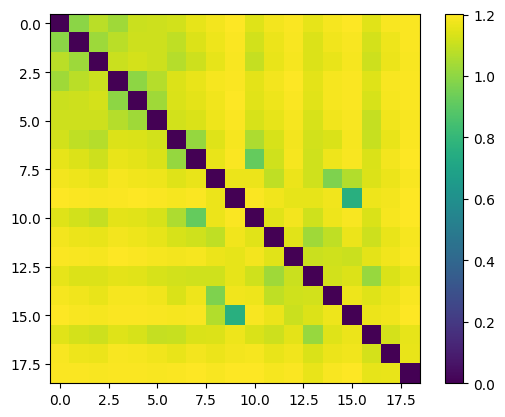

In [288]:
plt.imshow(D_train)
plt.colorbar();

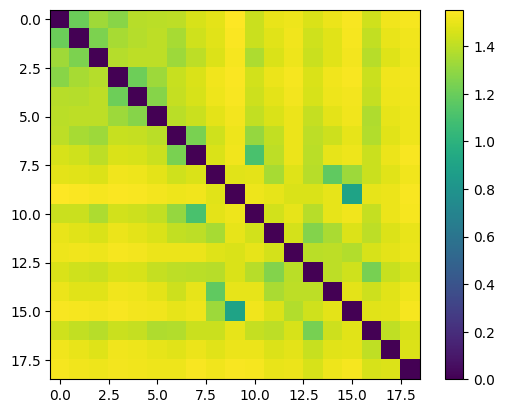

In [289]:
plt.imshow(D_test)
plt.colorbar();

TODO: cluster networks? Hierarchical clistering? PCA to try to get a "cortical map"

might need to: explore different PCA n_components (try higher values)